In [1]:
import pandas as pd
import numpy as np
import sklearn
import json
import time
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import eli5
import shap
from eli5.sklearn import PermutationImportance
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import partial_dependence
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
# from search_query import search
# from report_get import report
# from job_id_extract import job_id_extract
# from search_write_to_file import search_and_write
# from dict_make import dict_make
# from report_get_write_to_file import report_write
# from feature_extract import feature_extraction
# from target_extract import threat_score_extract
# from make_df import frame_maker

In [3]:
from the_functions import *

In [4]:
# dates_from = ['2020-09-28 00:00', '2020-09-29 00:00', '2020-9-30 00:00', '2020-10-01 00:00', '2020-10-02 00:00', '2020-10-03 00:00', '2020-10-04 00:00', '2020-10-05 00:00', '2020-10-06 00:00', '2020-10-07 00:00', '2020-10-08 00:00', '2020-10-09 00:00', '2020-10-10 00:00', '2020-10-11 00:00', '2020-10-12 00:00', '2020-10-13 00:00', '2020-10-14 00:00', '2020-10-15 00:00', '2020-10-16 00:00', '2020-10-17 00:00', '2020-10-18 00:00', '2020-10-19 00:00', '2020-10-20 00:00']
# dates_to = ['2020-09-29 00:00', '2020-09-30 00:00', '2020-10-01 00:00', '2020-10-02 00:00', '2020-10-03 00:00', '2020-10-04 00:00', '2020-10-05 00:00', '2020-10-06 00:00', '2020-10-07 00:00', '2020-10-08 00:00', '2020-10-09 00:00', '2020-10-10 00:00', '2020-10-11 00:00', '2020-10-12 00:00', '2020-10-13 00:00', '2020-10-14 00:00', '2020-10-15 00:00', '2020-10-16 00:00', '2020-10-17 00:00', '2020-10-18 00:00', '2020-10-19 00:00', '2020-10-20 00:00', '2020-10-21 00:00']

# Introduction, Business Understanding

Questions:
- How does Hybrid Analysis construct its threat score for URL's?
    - Can a generalized model be made based on the reports their Falcon Sandbox platform produces?
- What features are important to Hybrid Analysis URL threat score?
    - Can these features be determined, and then in turn, easily be extracted with guidance from their reports.
    - If reverse engineering isn't possible, can generealized insights still be produced?
    
Objectives:
- Creae a model that interprets Hybrid Analysis reports to determine threat score on URL's
- Create a feature list of Hybrid Analysis most informative features
- If the above are successful, deploy a reverse engineered model

Success Criteria:
- Either a functional model or insights into Hybrid Analysis feature importance for URL's that could guide another project

Hybrid Analysis:
- a website that allows users to submit malware, url's executables, html, etc for a proprietary "threat score" analysis.

# What have I done so far?

made search query and writing to file functions
made job_id extracting function that takes a dictionary input

can I get the things I need?
I need
- large set of malicious URL's
    - I can get these using my search and write function using a large enough window
- the malicious URLS's accompanying JOB id's
    - I can get these by extraccting the job ID's using my function on the dictionary
- Now I have job id's, target values, now I need features.
    - I need to use report get to get reports for each of my malicios URLS's I am storing that have the features
- Researching what is exactly contained in the feature reports
    - MUTEX (Mutual Exclusion) Locking down parts of code by keeping it in use, sometimes bloking visibility of other programs and making it immutable to outside other programs, think "file is in use somewhere else, cannot delete"

In [5]:
dates_from = ['2020-09-28 00:00', '2020-09-29 00:00', '2020-9-30 00:00', '2020-10-01 00:00', '2020-10-02 00:00', '2020-10-03 00:00', '2020-10-04 00:00', '2020-10-05 00:00', '2020-10-06 00:00', '2020-10-07 00:00', '2020-10-08 00:00', '2020-10-09 00:00', '2020-10-10 00:00', '2020-10-11 00:00', '2020-10-12 00:00', '2020-10-13 00:00', '2020-10-14 00:00', '2020-10-15 00:00', '2020-10-16 00:00', '2020-10-17 00:00', '2020-10-18 00:00', '2020-10-19 00:00', '2020-10-20 00:00','2020-10-21 00:00', '2020-10-22 00:00', '2020-10-23 00:00', '2020-10-24 00:00', '2020-10-25 00:00', '2020-10-26 00:00', '2020-10-27 00:00', '2020-10-28 00:00','2020-10-29 00:00', '2020-11-01 00:00', '2020-11-02 00:00', '2020-11-03 00:00', '2020-11-04 00:00', '2020-11-05 00:00', '2020-11-06 00:00', '2020-11-07 00:00', '2020-11-08 00:00', '2020-11-09 00:00', '2020-11-10 00:00', '2020-11-11 00:00', '2020-11-12 00:00', '2020-11-13 00:00', '2020-11-14 00:00', '2020-11-15 00:00', '2020-11-16 00:00', '2020-11-17 00:00', '2020-11-18 00:00', '2020-11-19 00:00', '2020-11-20 00:00', '2020-11-21 00:00', '2020-11-22 00:00', '2020-11-23 00:00', '2020-11-24 00:00', '2020-11-25 00:00']
dates_to = ['2020-09-29 00:00', '2020-09-30 00:00', '2020-10-01 00:00', '2020-10-02 00:00', '2020-10-03 00:00', '2020-10-04 00:00', '2020-10-05 00:00', '2020-10-06 00:00', '2020-10-07 00:00', '2020-10-08 00:00', '2020-10-09 00:00', '2020-10-10 00:00', '2020-10-11 00:00', '2020-10-12 00:00', '2020-10-13 00:00', '2020-10-14 00:00', '2020-10-15 00:00', '2020-10-16 00:00', '2020-10-17 00:00', '2020-10-18 00:00', '2020-10-19 00:00', '2020-10-20 00:00', '2020-10-21 00:00', '2020-10-22 00:00', '2020-10-23 00:00', '2020-10-24 00:00', '2020-10-25 00:00', '2020-10-26 00:00', '2020-10-27 00:00', '2020-10-28 00:00','2020-10-29 00:00', '2020-11-01 00:00', '2020-11-02 00:00', '2020-11-03 00:00', '2020-11-04 00:00', '2020-11-05 00:00', '2020-11-06 00:00', '2020-11-07 00:00', '2020-11-08 00:00', '2020-11-09 00:00', '2020-11-10 00:00', '2020-11-11 00:00', '2020-11-12 00:00', '2020-11-13 00:00', '2020-11-14 00:00', '2020-11-15 00:00', '2020-11-16 00:00', '2020-11-17 00:00', '2020-11-18 00:00', '2020-11-19 00:00', '2020-11-20 00:00', '2020-11-21 00:00', '2020-11-22 00:00', '2020-11-23 00:00', '2020-11-24 00:00', '2020-11-25 00:00', '2020-11-26 00:00']

In [6]:
# len(search('2020-09-28 00:00', '2020-09-29 00:00', 5))

In [7]:
# search_and_write(dates_from, dates_to)

In [8]:
# with open('data/data0.txt') as json_file:
#     data = json.load(json_file)
# data

In [9]:
my_dict = dict_make(dates_from)

In [10]:
my_list = job_id_extract(my_dict)

In [11]:
# report_write(my_list)

In [12]:
# with open('reports/reports5f7e47fdb8e47e68de0a152a.txt') as json_file:
#     data = json.load(json_file)
# data

In [13]:
# rep = report("5f9a05839fb71b523c1a2b59")
# rep

In [14]:
# frequencies2 = {}
# for i in rep2['response']['Event']['Attribute']:
#     if i['category'] in frequencies2:
#         frequencies2[i['category']] += 1
#     else:
#         frequencies2[i['category']] = 1
# print(frequencies2)
# d = []
# for i in frequencies2.values():
#     d.append(i)
# d

In [15]:
# frequencies = {}
# for i in rep['response']['Event']['Attribute']:
#     if i['category'] in frequencies:
#         frequencies[i['category']] += 1
#     else:
#         frequencies[i['category']] = 1
# print(frequencies)
# d = []
# for i in frequencies.values():
#     d.append(i)
# d

In [16]:
# list = []
# for i in rep['response']['Event']['Attribute']:
#     list.append(i['category'])
# for i in range(len(list)):
#     if list[i] == list[i-1]:
#         print('fizz')
#     else:
#         print('buzz')

# counted = Counter(list)
# for i in counted

In [17]:
# #count unique categories
# category_list = []
# for i in rep['response']['Event']['Attribute']:
#     category_list.append(i['category'])
# set(category_list)
# # one_hot = []
# # if 'Artifacts dropped' in set(list):
# #     one_hot.append(1)
    
# # else:
# #     one_hot.append(0)
# # one_hot

# # for i in set(list):
# #     print('this could be it')

In [18]:
# #count unique types
# clist = []
# for i in rep['response']['Event']['Attribute']:
#     clist.append(i['type'])
# clist
# set(clist)

In [19]:
# list_type = []
# list_category = []
# for i in my_list:
#     with open(f'reports/reports{i}.txt') as json_file:
#         features = []
#         job_id = i
#         x = json.load(json_file)
        
#         for i in x['response']['Event']['Attribute']:
#             list_category.append(i['category'])
        
        
#         for i in x['response']['Event']['Attribute']:
#             list_type.append(i['type'])
# print(set(list_type), set(list_category))

In [20]:
# p = set(clist) - set(list_type)
# p

In [21]:
# for i in os.listdir('reports'):
#     try:
#         with open(f'{i}') as json_file:
#             x = json.load(json_file)
#             print(x)
#     except:
#         print(i)

In [22]:
# # can open all files in reports - this will become my core feature extraction
# a_dict = {}
# category_list = ['Artifacts dropped', 'External analysis', 'Network activity', 'Payload delivery', 'Payload installation', 'Persistence mechanism']
# types_list = ['filename|md5', 'user-agent', 'domain|ip', 'mutex', 'ip-dst', 'regkey|value', 'comment', 'filename|sha512', 'domain', 'filename|sha256', 'link', 'filename|sha1']
# for i in my_list:
#     with open(f'reports/reports{i}.txt') as json_file:
#         features = []
#         job_id = i
#         x = json.load(json_file)
        
        
#         #acg length of attribute vlaues
#         lenRep = len(x['response']['Event']['Attribute'])
#         list_of_lengths = []
#         sum = 0
        
#         for i in x['response']['Event']['Attribute']:
#             list_of_lengths.append(i['value'])
#         for i in list_of_lengths:
#             sum += len(i)
#         avg_len = (sum/lenRep)
        
#         features.append(avg_len)
        
        
#         # total length of attribute values
#         list_of_lengths = []
#         sum = 0
        
#         for i in x['response']['Event']['Attribute']:
#             list_of_lengths.append(i['value'])
#         for i in list_of_lengths:
#             sum += len(i)
        
#         features.append(sum)
        
#         # count of categories
#         list = []
#         for i in x['response']['Event']['Attribute']:
#             list.append(i['category'])
#         len_list = len(list)
        
#         features.append(len_list)
        
#         # one hotting categories
#         cats = []
#         for i in x['response']['Event']['Attribute']:
#             cats.append(i['category'])
#         cats = set(cats)
#         for i in category_list:
#             if i in cats:
#                 features.append(1)
#             else:
#                 features.append(0)
        
#         types = []
#         for i in x['response']['Event']['Attribute']:
#             types.append(i['type'])
#         types = set(types)
#         for i in types_list:
#             if i in types:
#                 features.append(1)
#             else:
#                 features.append(0)
        
        
#         a_dict[f'{job_id}'] = features
# a_dict

In [23]:
a_dict = feature_extraction(my_list)

In [24]:
len(my_list)

420

In [25]:
df = frame_maker(a_dict, my_dict)

In [26]:
df

,job_id,avg_val_len,total_val_len,category_count,Artifacts dropped,External analysis,Network activity,Payload delivery,Payload installation,Persistence mechanism,...,filename|sha256,link,filename|sha1,EA_count,PD_count,NA_count,PI_count,PM_count,AD_count,target
0,5f72774a50643e7bc7460603,102.382143,86001.0,840.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,2.0,4.0,129.0,548.0,112.0,45.0,100
1,5f7274e3e6faf447dd379eca,128.876732,176690.0,1371.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,2.0,4.0,118.0,1060.0,122.0,65.0,90
2,5f72734166e01f097b2eeb44,123.602110,164020.0,1327.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,2.0,4.0,37.0,1132.0,106.0,46.0,55
3,5f7271bd57dba718d1561324,117.141732,59508.0,508.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,2.0,4.0,13.0,316.0,112.0,61.0,41
4,5f751bc17735bd73cb45719f,152.422642,40392.0,265.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,2.0,4.0,7.0,100.0,103.0,49.0,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,5f99f6f663cbb702751cd2f3,195.929231,63677.0,325.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,2.0,4.0,3.0,152.0,109.0,55.0,81
195,5f99f672d9283a0ceb566904,145.464156,119717.0,823.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,2.0,4.0,80.0,496.0,180.0,61.0,82
196,5f99f66411eaeb0ff5492f5a,148.726597,100093.0,673.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,2.0,4.0,64.0,448.0,109.0,46.0,82
197,5f99f6566827750c120076c5,134.207477,143602.0,1070.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,2.0,4.0,106.0,752.0,155.0,51.0,79


# features

need to save a job ID for any kind of feature extraction, probably create a dictionary? creating values for columns? 'count_unique_categories':5, 'total_categories':153

couunt unique categories: each report has categories of nefarious things a url possesses. reachable by rep['response']['Event']['Attribute'] -> i['category']

```
list = []
for i in rep['response']['Event']['Attribute']:
    list.append(i['category'])
list
set(list)
```

avg length of categories values: these are usually just a hash, but it's still information, found in rep['response']['Event']['Attribute']['value']
```
lenRep = len(rep['response']['Event']['Attribute'])
list = []
sum = 0
for i in rep['response']['Event']['Attribute']:
    list.append(i['value'])
for i in list:
    sum += len(i)
sum/lenRep
```

total length of category values : same as above but just sum
```
lenRep = len(rep['response']['Event']['Attribute'])
list = []
sum = 0
for i in rep['response']['Event']['Attribute']:
    list.append(i['value'])
for i in list:
    sum += len(i)
sum/lenRep
```

rep['response']['Event']['Attribute'][i] - the i here is arbitrary, but what this does is drills down to the features, the 'attributes' are the features, mutex, payload delivery, persistence mechanism etc. can just count the number of attributes. If you add ['value'] to the end of the statement it gets the values of i which is typically a something with a hash?

avg length of value in payload_delivery

- can just use both on any number of feature possibilities

max length of something/anything

distance between feature_id 1 and 2 != 2 and 3

In [27]:
desc_stats = df.describe()

In [28]:
# desc_stats.to_csv('desc_stats.csv')

In [29]:
df

,job_id,avg_val_len,total_val_len,category_count,Artifacts dropped,External analysis,Network activity,Payload delivery,Payload installation,Persistence mechanism,...,filename|sha256,link,filename|sha1,EA_count,PD_count,NA_count,PI_count,PM_count,AD_count,target
0,5f72774a50643e7bc7460603,102.382143,86001.0,840.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,2.0,4.0,129.0,548.0,112.0,45.0,100
1,5f7274e3e6faf447dd379eca,128.876732,176690.0,1371.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,2.0,4.0,118.0,1060.0,122.0,65.0,90
2,5f72734166e01f097b2eeb44,123.602110,164020.0,1327.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,2.0,4.0,37.0,1132.0,106.0,46.0,55
3,5f7271bd57dba718d1561324,117.141732,59508.0,508.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,2.0,4.0,13.0,316.0,112.0,61.0,41
4,5f751bc17735bd73cb45719f,152.422642,40392.0,265.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,2.0,4.0,7.0,100.0,103.0,49.0,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,5f99f6f663cbb702751cd2f3,195.929231,63677.0,325.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,2.0,4.0,3.0,152.0,109.0,55.0,81
195,5f99f672d9283a0ceb566904,145.464156,119717.0,823.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,2.0,4.0,80.0,496.0,180.0,61.0,82
196,5f99f66411eaeb0ff5492f5a,148.726597,100093.0,673.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,2.0,4.0,64.0,448.0,109.0,46.0,82
197,5f99f6566827750c120076c5,134.207477,143602.0,1070.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,2.0,4.0,106.0,752.0,155.0,51.0,79


In [30]:
# df.columns.tolist()

In [31]:
# df.dtypes

In [32]:
df = df.drop(columns = 'job_id')

In [33]:
df.index[df['avg_val_len'] > 500].tolist()

[24]

In [34]:
df = df.drop(index=24)

In [35]:
X = df.drop(columns = 'target')
y = df['target']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=2)

In [37]:
rfr = RandomForestRegressor(n_estimators=500, max_depth=3, random_state=5)
gbr = GradientBoostingRegressor(max_depth=1)

In [38]:
rfr.fit(X_train, y_train)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=1)

In [39]:
pred = rfr.predict(X_test)
pred_gbr = gbr.predict(X_test)

In [40]:
print(mean_squared_error(y_test, pred),
mean_squared_error(y_test, pred_gbr))

254.30464096097836 274.23809670759204


In [41]:
print('R2:',rfr.score(X_train, y_train), 'MSE:', mean_squared_error(y_test, pred), '\n', rfr)

R2: 0.46507373564315646 MSE: 254.30464096097836 
 RandomForestRegressor(max_depth=3, n_estimators=500, random_state=5)


In [42]:
print('R2:', rfr.score(X_test, y_test))

R2: -0.05820764924425115


In [43]:
tuned_parameters = {'n_estimators': [200,500, 700, 1000], 'max_depth': [1,2,3], 'min_samples_split':[2,3,4]}
clf = GridSearchCV(RandomForestRegressor(), tuned_parameters, cv=5, 
                   n_jobs=-1, verbose=1)
clf.fit(X_train, y_train)
print(clf.best_estimator_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
RandomForestRegressor(max_depth=3, n_estimators=500)


In [44]:
rfr = clf.best_estimator_

In [45]:
selector = RFE(rfr, n_features_to_select=4, step=1)
selector.fit(X_train, y_train)
p = selector.get_support(1)
X_train_rfe = X_train[X_train.columns[p]]
X_test_rfe = X_test[X_test.columns[p]]
rfr.fit(X_train_rfe, y_train)
rfr.score(X_train_rfe, y_train)

0.4526653519523923

In [46]:
selector.get_support(1)

array([ 0,  1, 23, 25])

In [47]:
X_train.columns[25]

'PM_count'

In [48]:
tuned_parameters = {'n_estimators': [200,500, 700, 1000], 'max_depth': [1,2,3], 'min_samples_split':[2,3,4]}
clf = GridSearchCV(RandomForestRegressor(), tuned_parameters, cv=5, 
                   n_jobs=-1, verbose=1)
clf.fit(X_train_rfe, y_train)
print(clf.best_estimator_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
RandomForestRegressor(max_depth=3, n_estimators=500)


In [49]:
rfr = clf.best_estimator_

In [50]:
rfr.score(X_test_rfe, y_test)

-0.09044416683758949

In [51]:
gbr.score(X_train, y_train)

0.41510282651704233

In [52]:
gbr.score(X_test, y_test)

-0.1411543672720006

In [53]:
selector = RFE(rfr, n_features_to_select=4, step=1)
selector.fit(X_train, y_train)
p = selector.get_support(1)
X_train_rfe = X_train[X_train.columns[p]]
X_test_rfe = X_test[X_test.columns[p]]
rfr.fit(X_train_rfe, y_train)
rfr.score(X_train_rfe, y_train)


0.4538855079920048

In [54]:
gbr.fit(X_train_rfe, y_train)
gbr.score(X_test_rfe, y_test)

-0.029127201115699775

In [55]:
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=3, n_estimators=500)

In [56]:
perm_model = PermutationImportance(rfr, random_state = 1).fit(X_train, y_train)
eli5.show_weights(perm_model, feature_names = X_train.columns.to_list())

Weight,Feature
0.4520 ± 0.1219,NA_count
0.1242 ± 0.0827,PM_count
0.1200 ± 0.0187,avg_val_len
0.0576 ± 0.0215,total_val_len
0.0268 ± 0.0044,category_count
0.0237 ± 0.0100,domain
0.0220 ± 0.0020,PI_count
0.0125 ± 0.0032,user-agent
0.0091 ± 0.0035,AD_count
0.0000 ± 0.0000,mutex


In [57]:
perm_model = PermutationImportance(rfr, random_state = 1).fit(X_test, y_test)
eli5.show_weights(perm_model, feature_names = X_train.columns.to_list())

Weight,Feature
0.0290 ± 0.1561,NA_count
0.0152 ± 0.0322,total_val_len
0.0042 ± 0.0075,PI_count
0.0033 ± 0.0172,AD_count
0.0009 ± 0.0066,user-agent
0.0004 ± 0.0132,category_count
0.0003 ± 0.0000,Artifacts dropped
0.0002 ± 0.0000,Payload installation
0 ± 0.0000,External analysis
0 ± 0.0000,Network activity


In [58]:
rfr.fit(X_train_rfe, y_train)

RandomForestRegressor(max_depth=3, n_estimators=500)

In [59]:
perm_model = PermutationImportance(rfr, random_state = 1).fit(X_train_rfe, y_train)
eli5.show_weights(perm_model, feature_names = X_train_rfe.columns.to_list())

Weight,Feature
0.5809 ± 0.0799,NA_count
0.1388 ± 0.0377,PM_count
0.1277 ± 0.0268,avg_val_len
0.0707 ± 0.0204,total_val_len


In [60]:
perm_model = PermutationImportance(rfr, random_state = 1).fit(X_test_rfe, y_test)
eli5.show_weights(perm_model, feature_names = X_train_rfe.columns.to_list())

Weight,Feature
0.1357 ± 0.2267,NA_count
0.0208 ± 0.0368,total_val_len
0.0031 ± 0.0165,PM_count
-0.0870 ± 0.1230,avg_val_len


In [ ]:
# tuned_parameters = {'n_estimators': [500, 700, 1000], 'max_depth': [1, 2, 3, 4, 5, 6]}
# clf = GridSearchCV(RandomForestRegressor(), tuned_parameters, cv=5, 
#                    n_jobs=-1, verbose=1)
# clf.fit(X_train, y_train)
# print(clf.best_estimator_)

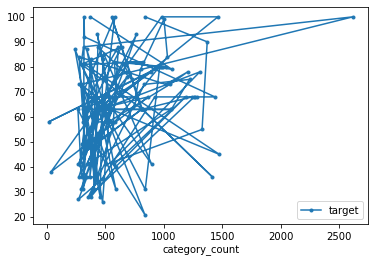

In [64]:
df.plot(x='category_count', y='target', marker='.')

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


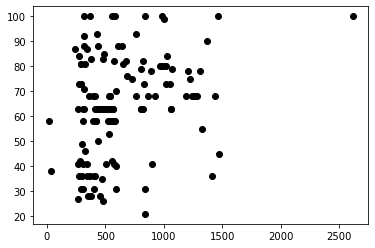

In [65]:
x = df['category_count']
y = df['target']
plt.plot(x, y, 'o', color='black');

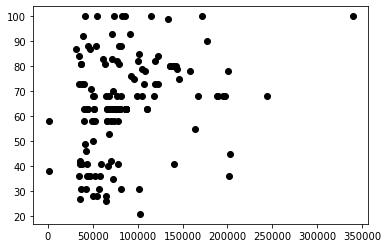

In [66]:
x = df['total_val_len']
y = df['target']
plt.plot(x, y, 'o', color='black');

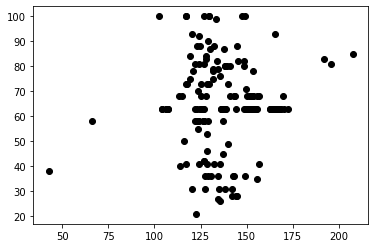

In [67]:
x = df['avg_val_len']
y = df['target']
plt.plot(x, y, 'o', color='black');

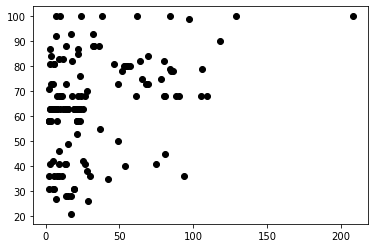

In [68]:
x = df['NA_count']
y = df['target']
plt.plot(x, y, 'o', color='black');

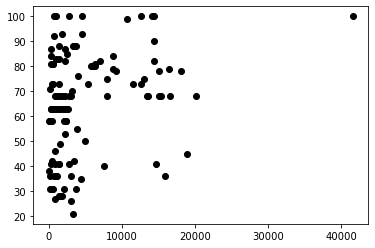

In [69]:
x = df['PM_count']*df['NA_count']
y = df['target']
plt.plot(x, y, 'o', color='black');

In [70]:
X_samp = X_train.sample(random_state=1, n=1)
explainer = shap.TreeExplainer(rfr)
shap_val = explainer.shap_values(X_samp)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_val, X_samp)

In [71]:
X_samp = X_train.sample(random_state=2, n=1)
explainer = shap.TreeExplainer(rfr)
shap_val = explainer.shap_values(X_samp)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_val, X_samp)

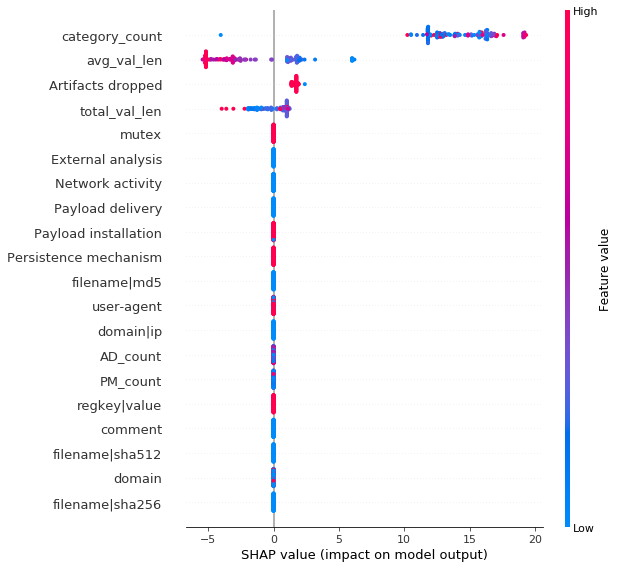

In [72]:
shap_values = shap.TreeExplainer(rfr).shap_values(X_train)
shap.summary_plot(shap_values, X_train)

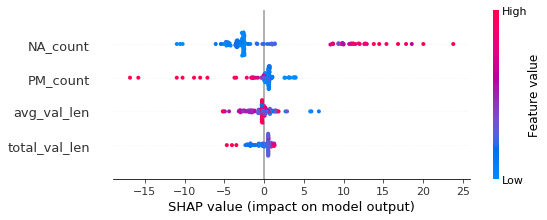

In [78]:
rfr.fit(X_train_rfe, y_train)
shap_values = shap.TreeExplainer(rfr).shap_values(X_train_rfe)
shap.summary_plot(shap_values, X_train_rfe)

In [96]:
X_samp = X_train_rfe.sample(random_state=2, n=1)
explainer = shap.TreeExplainer(rfr)
shap_val = explainer.shap_values(X_samp)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_val, X_samp)

In [97]:
X_samp = X_train_rfe.sample(random_state=3, n=1)
explainer = shap.TreeExplainer(rfr)
shap_val = explainer.shap_values(X_samp)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_val, X_samp)

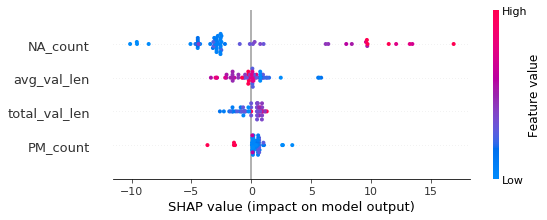

In [85]:
shap_values = shap.TreeExplainer(rfr).shap_values(X_test_rfe)
shap.summary_plot(shap_values, X_test_rfe)

In [73]:
pca = PCA(2)
df = pca.fit_transform(X_train)
kmeans = KMeans(n_clusters=3)
label = kmeans.fit_predict(df)

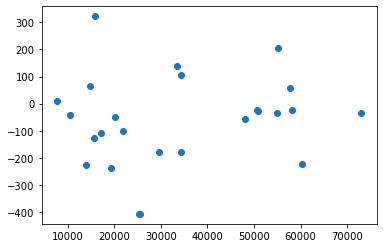

In [74]:
#filter rows of original data
filtered_label0 = df[label == 0]
 
#plotting the results
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1])
plt.show()

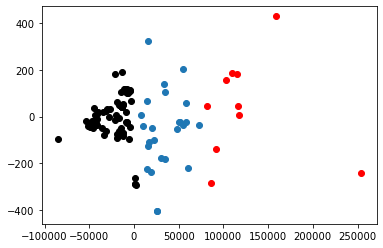

In [75]:
#filter rows of original data
filtered_label2 = df[label == 2]
filtered_label0 = df[label == 0]
filtered_label8 = df[label == 1]
 
#Plotting the results
plt.scatter(filtered_label2[:,0] , filtered_label2[:,1] , color = 'red')
plt.scatter(filtered_label8[:,0] , filtered_label8[:,1] , color = 'black')
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1])
plt.show()

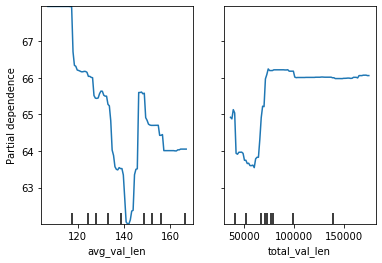

In [77]:
plot_partial_dependence(rfr, X, features=[0,1]) 

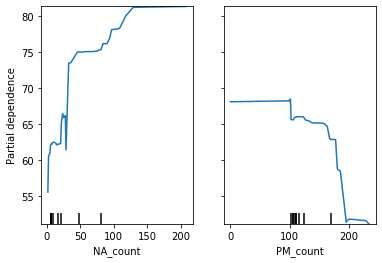

In [92]:
plot_partial_dependence(rfr, X_train_rfe, features=[2,3]) 

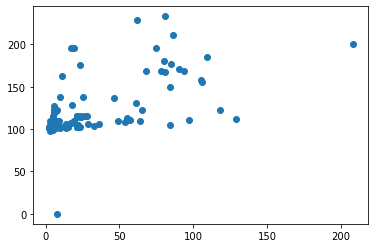

In [95]:
plt.scatter(X_train_rfe['NA_count'], X_train_rfe['PM_count'])

AttributeError: 'RandomForestRegressor' object has no attribute 'x'